In [1]:
from network_lib import *

In [2]:
import hls4ml
import plotting

In [3]:
data = True
mask_min = 134
mask_max = 170
if data:
    MASK = np.logical_or(np.logical_and(np.logical_and(train_y[:,2]<mask_max,train_y[:,2]>mask_min),np.logical_and(train_y[:,3]<mask_max,train_y[:,3]>mask_min)),np.logical_and(train_y[:,0]==0,train_y[:,1]==0))
    #MASK2 = np.logical_and(np.logical_and(train2_y[:,2]<180,train2_y[:,2]>80),np.logical_and(train2_y[:,3]<200,train2_y[:,3]>100))
    train3_x = train_x[MASK,mask_min:mask_max,mask_min:mask_max]
    train_y = train_y[MASK]
    train3_y = train2_y[MASK]
    '''
    for name in Minbiastrainlist:
        MBtrain = MinBiastrainstorage[name]
        MBimage = get_images_allslices(MBtrain)
        for f in MBimage:
            for g in f:
                _img = np.sum(g,axis=0)
                img = _img[:,:-8].reshape(*_img[:,:-8].shape,1)[80:180,100:200]
                train_x = np.append(train_x,[img],axis=0) # all permutaions of min_bias and lone_muon
                train3_y = np.append(train3_y,[np.array([0,1])],axis=0)
    import pickle
    output = open('train3x.pkl', 'wb')
    pickle.dump(train_x, output)
    output.close()
    output = open('train3y.pkl', 'wb')
    pickle.dump(train3_y, output)
    output.close()
    '''
    validMASK = np.logical_or(np.logical_and(np.logical_and(valid_y[:,2]<mask_max,valid_y[:,2]>mask_min),np.logical_and(valid_y[:,3]<mask_max,valid_y[:,3]>mask_min)),np.logical_and(valid_y[:,0]==0,valid_y[:,1]==0))
    valid3_y = valid2_y[validMASK]
    valid_x = valid_x[validMASK,mask_min:mask_max,mask_min:mask_max]
    testMASK = np.logical_or(np.logical_and(np.logical_and(test_y[:,2]<mask_max,test_y[:,2]>mask_min),np.logical_and(test_y[:,3]<mask_max,test_y[:,3]>mask_min)),np.logical_and(test_y[:,0]==0,test_y[:,1]==0))
    test3_y = test2_y[testMASK]
    test_x = test_x[testMASK,mask_min:mask_max,mask_min:mask_max]
else:
    objectRep = open("train3x.pkl", "rb")
    train3_x = pickle.load(objectRep)
    objectRep.close()
    objectRep = open("train3y.pkl", "rb")
    train3_y = pickle.load(objectRep)
    objectRep.close()

In [6]:
CPU = True
if CPU:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [7]:
model = network2(with_dropout=False)
model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 36, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 34, 34, 16)        144       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 34, 34, 16)       64        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 34, 34, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (N

In [8]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
NSTEPS = len(train3_x[:6000])  // 8
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs, 
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = 0.50, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*10, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 76


/home/camplani/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  mask = self.add_variable(
/home/camplani/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  threshold = self.add_variable(
/home/camplani/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.pruning_step = self.add_variable(


In [9]:
train_pruned_small = False # True if you want to retrain, false if you want to load a previsously trained model
train_pruned = False
load_small = True
STEPS_PER_EPOCH = int(len(train_x))  // batch_size
boundaries = [STEPS_PER_EPOCH*40]
values = [0.001, 0.0001]


if train_pruned_small:
    logs_pruned = 'logs/small_log_pruned'
    n_epochs = 10
    callback = [tf.keras.callbacks.TensorBoard(log_dir = logs_pruned, histogram_freq = 1, profile_batch = '500,1000'),tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),pruning_callbacks.UpdatePruningStep()]
    #lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    LOSS        = tf.keras.losses.CategoricalCrossentropy()#tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

    start = time.time()
    model_pruned.fit(train3_x[:6000],train3_y[:6000],
                     epochs = n_epochs, batch_size=8,validation_data=(valid_x, valid3_y),callbacks=callback)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model_pruned.save('small_pruned_cnn_model36.h5')
    
elif train_pruned:
    logs_pruned = 'logs/log_pruned'
    n_epochs = 1500
    callback = [tf.keras.callbacks.TensorBoard(log_dir = logs_pruned, histogram_freq = 1, profile_batch = '500,1000'),pruning_callbacks.UpdatePruningStep()]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    LOSS        = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

    start = time.time()
    model_pruned.fit(train_x,train_set_y,
                     epochs = n_epochs, batch_size=batch_size,validation_data=(valid_x, valid_y),callbacks=callback)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model_pruned.save('small_pruned_cnn_model.h5')

elif load_small:
    logs_pruned = 'logs/small_log_pruned'
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('small_pruned_cnn_model36.h5', custom_objects=co)
else:
    logs_pruned = 'logs/log_pruned'
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('small_pruned_cnn_model.h5', custom_objects=co)

In [10]:
train_cnn_small = False # True if you want to retrain, false if you want to load a previsously trained model
train_cnn = False
load_small = True
STEPS_PER_EPOCH = int(len(train_x))  // batch_size
boundaries = [STEPS_PER_EPOCH*80]
values = [0.001, 0.0001]


if train_cnn_small:
    logs_cnn = 'logs/small_log_cnn'
    n_epochs = 10
    callback = [tf.keras.callbacks.TensorBoard(log_dir = logs_cnn, histogram_freq = 1, profile_batch = '500,1000'),tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)]
    #lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    LOSS        = tf.keras.losses.CategoricalCrossentropy()#tf.keras.losses.BinaryCrossentropy(from_logits=True)#tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')#tf.keras.losses.CategoricalCrossentropy()#
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

    start = time.time()
    model.fit(train3_x[:6000],train3_y[:6000],
                     epochs = n_epochs, batch_size=8,validation_data=(valid_x, valid3_y),callbacks=callback)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model.save('small_cnn_model36.h5')
elif train_cnn:
    logs_cnn = 'logs/log_cnn'
    n_epochs = 1500
    callback = [tf.keras.callbacks.TensorBoard(log_dir = logs_cnn, histogram_freq = 1, profile_batch = '500,1000')]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    LOSS        = tf.keras.losses.CategoricalCrossentropy()#tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

    start = time.time()
    model.fit(train_x,train_y,
                     epochs = n_epochs, batch_size=batch_size,validation_data=(valid_x, valid_y),callbacks=callback)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model.save('cnn_model.h5')
elif load_small:
    logs_cnn = 'logs/small_log_cnn'
    model = tf.keras.models.load_model('small_cnn_model36.h5')
else:
    logs_cnn = 'logs/log_cnn'
    model = tf.keras.models.load_model('cnn_model.h5')

In [11]:
#baseline_pruned            = model_pruned(test_x, training = False)
predict_baseline_pruned    = model_pruned.predict(test_x)
test_score_baseline_pruned = model_pruned.evaluate(test_x, test3_y)

3/3 [==============================] - 0s 6ms/step - loss: 0.6034 - accuracy: 0.7692


In [12]:
#baseline_pruned            = model(test_x, training = False)
predict_baseline   = model.predict(test_x)
test_score_baseline = model.evaluate(test_x, test3_y)

3/3 [==============================] - 0s 5ms/step - loss: 0.6058 - accuracy: 0.6813


Plotting ROC for labels ['Muon', 'Background']


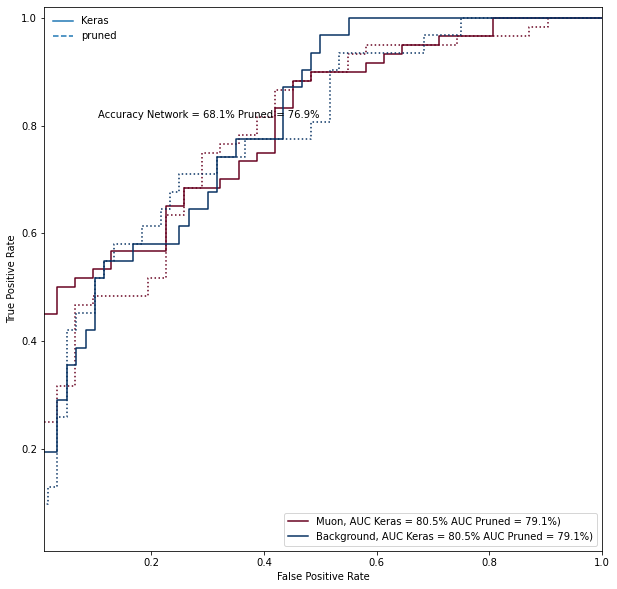

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels=['Muon','Background'] # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_p = pd.DataFrame()
fpr  = {}
tpr  = {}
auc1 = {}
fpr_p  = {}
tpr_p  = {}
auc1_p = {}
%matplotlib inline
colors  = ['#67001f','#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = test3_y[:,i]
    df[label + '_pred'] = predict_baseline[:,i]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label],df[label+'_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])
    
    df_p[label] = test3_y[:,i]
    df_p[label + '_pred'] = predict_baseline_pruned[:,i]
    fpr_p[label], tpr_p[label], threshold_p = metrics.roc_curve(df_p[label],df_p[label+'_pred'])
    auc1_p[label] = metrics.auc(fpr_p[label], tpr_p[label])
    
    plt.plot(fpr[label],tpr[label]    ,label=r'{}, AUC Keras = {:.1f}% AUC Pruned = {:.1f}%)'.format(label,auc1[label]*100,auc1_p[label]*100), linewidth=1.5,c=colors[i],linestyle='solid')
    plt.plot(fpr_p[label],tpr_p[label], linewidth=1.5,c=colors[i],linestyle='dotted')

#plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01,1.)
plt.ylim(0.01,1.02)
plt.legend(loc='lower right')
plt.figtext(0.2, 0.73,r'Accuracy Network = {:.1f}% Pruned = {:.1f}%'.format(test_score_baseline[1]*100,test_score_baseline_pruned[1]*100), wrap=True, horizontalalignment='left',verticalalignment='center')
from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['Keras', 'pruned'],
            loc='upper left', frameon=False)
ax.add_artist(leg)

In [14]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'latency_muon/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_latency = hls4ml.converters.keras_to_hls(cfg)
hls_model_latency.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

In [15]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'resource_muon/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_resource = hls4ml.converters.keras_to_hls(cfg)
hls_model_resource.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

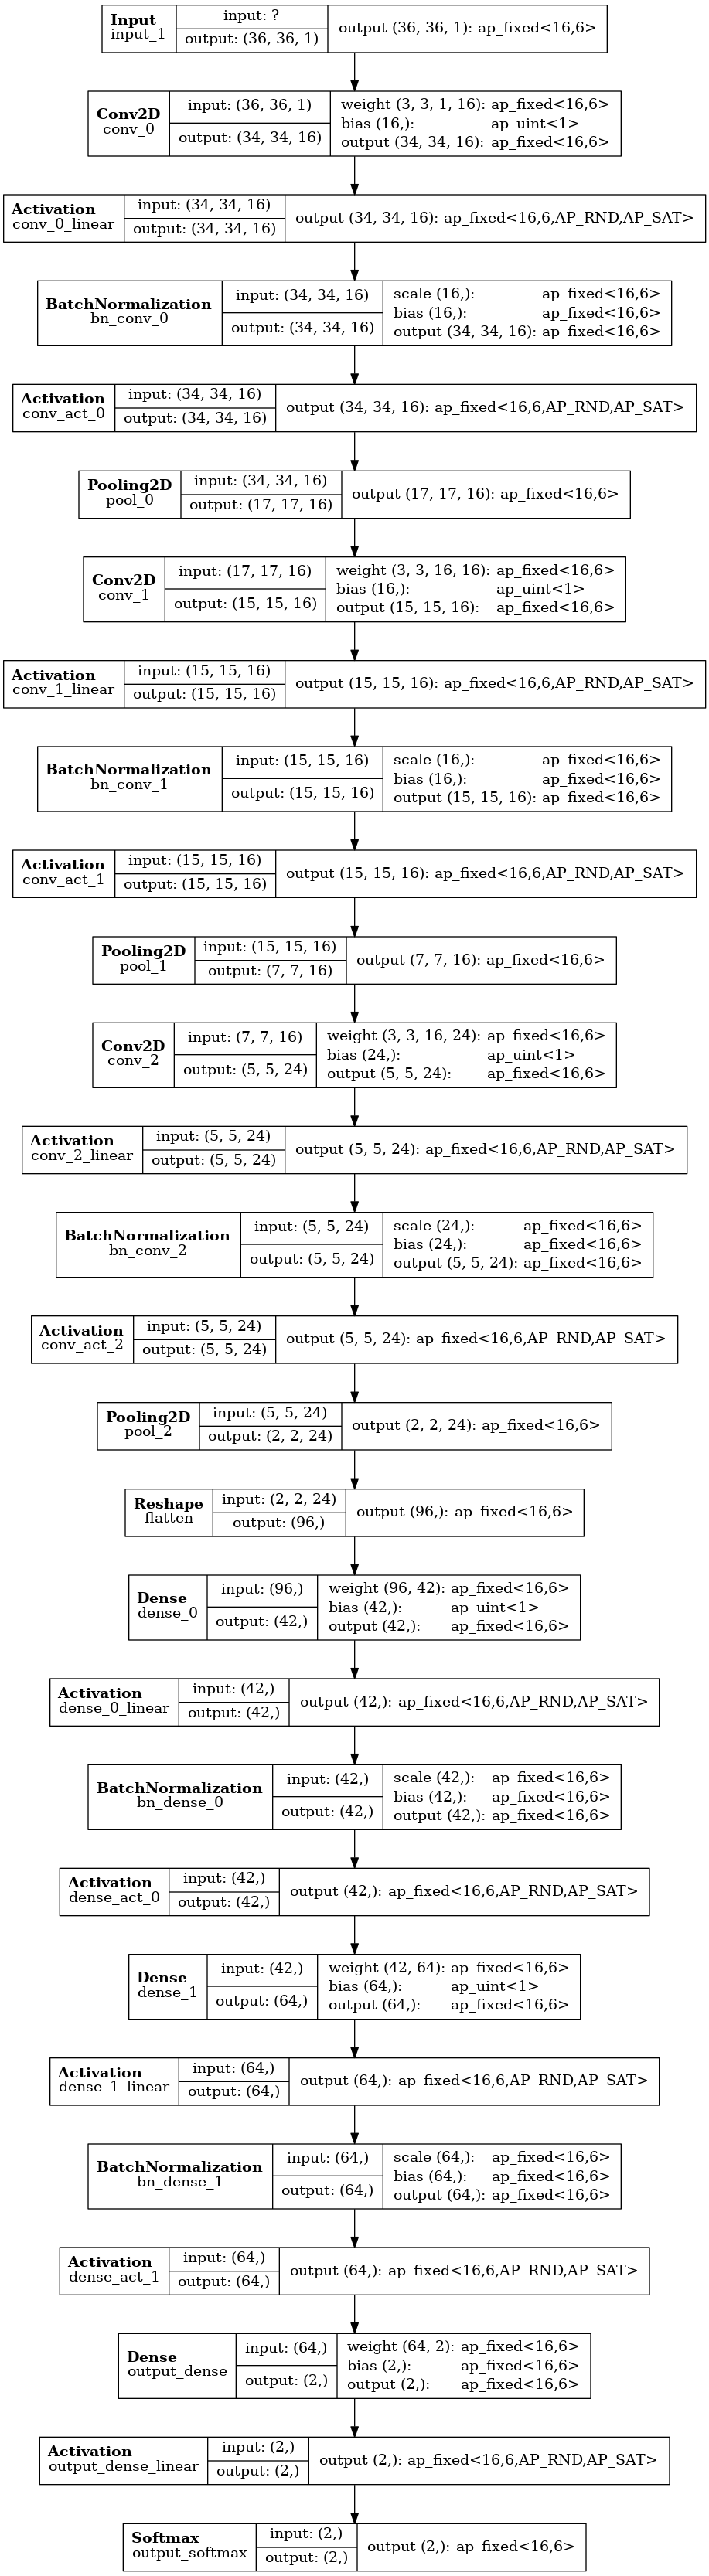

In [16]:
hls4ml.utils.plot_model(hls_model_latency, show_shapes=True, show_precision=True, to_file=None)

In [17]:
#hls4ml.utils.plot_model(hls_model_resource, show_shapes=True, show_precision=True, to_file=None)

In [18]:
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model_latency)

In [19]:
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model_resource)

In [20]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model_pruned  = strip_pruning(model_pruned)

In [21]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model_pruned, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
cfg['KerasModel'] = model_pruned
cfg['OutputDir']  = 'pruned_latency_muon/'

hls_model_latency_pruned = hls4ml.converters.keras_to_hls(cfg)
hls_model_latency_pruned.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

In [22]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model_pruned, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
cfg['KerasModel'] = model_pruned
cfg['OutputDir']  = 'pruned_resource_muon/'


hls_model_resource_pruned = hls4ml.converters.keras_to_hls(cfg)
hls_model_resource_pruned.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

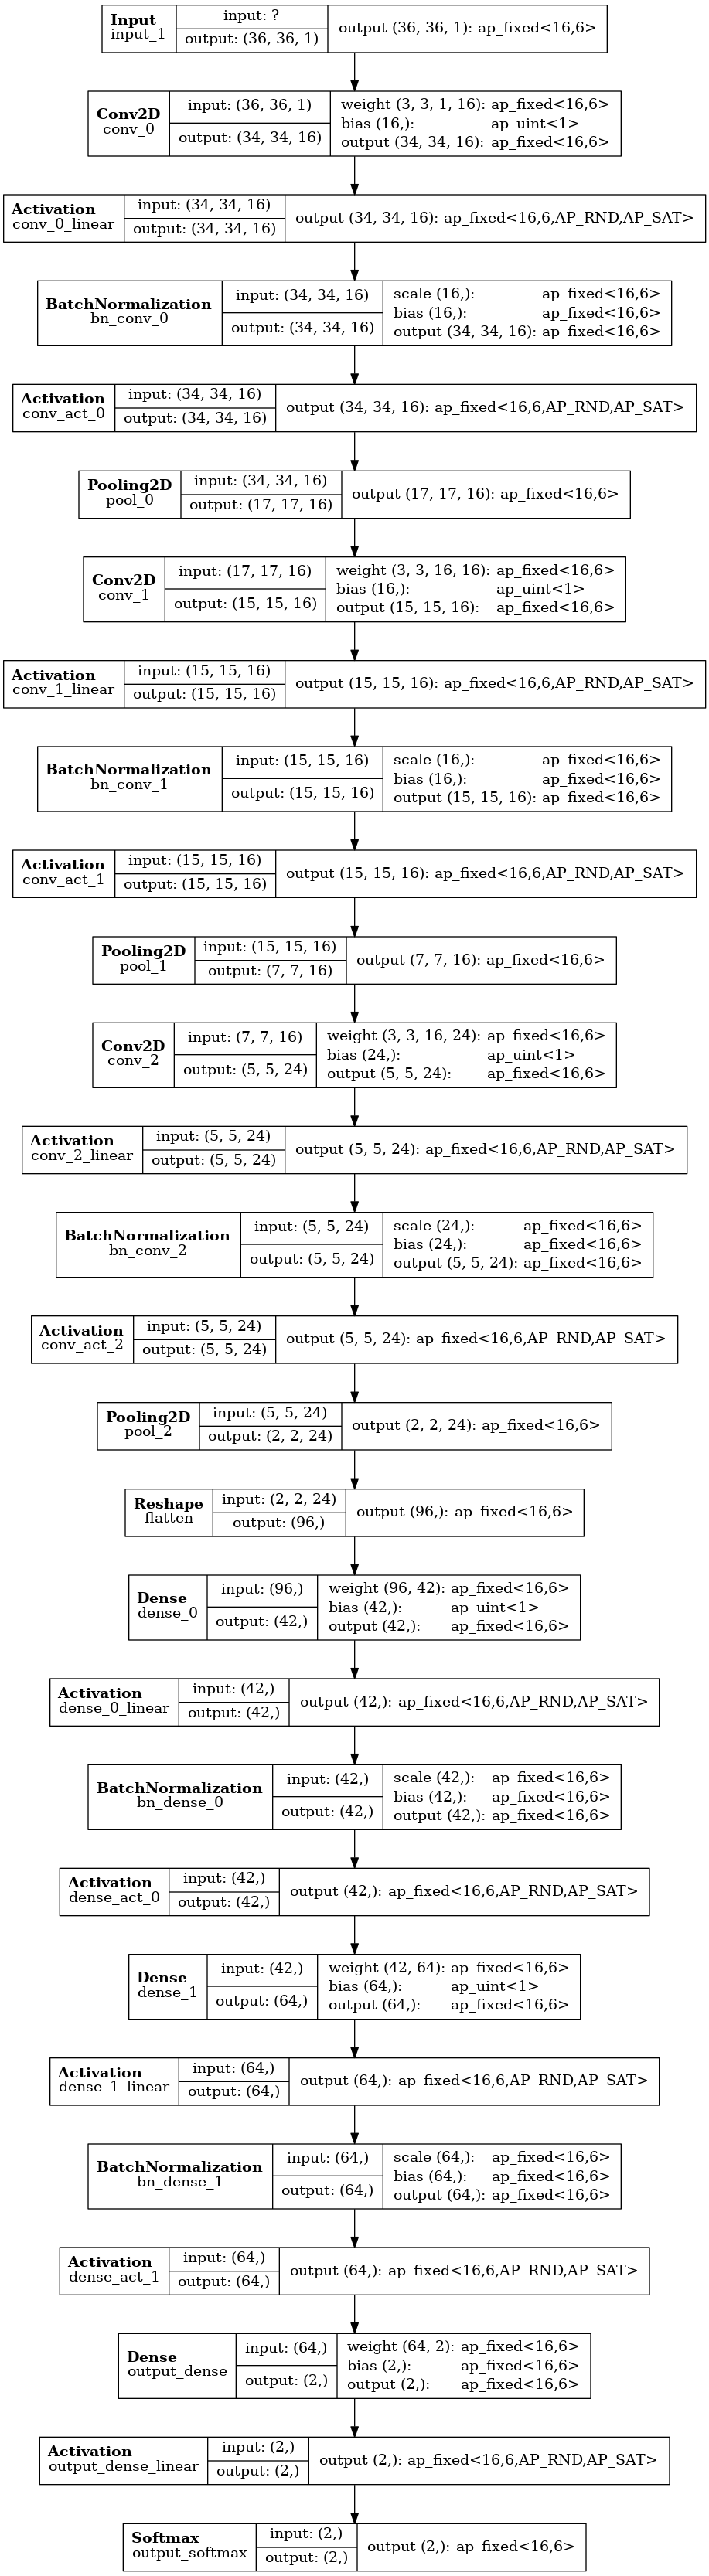

In [23]:
hls4ml.utils.plot_model(hls_model_latency_pruned, show_shapes=True, show_precision=True, to_file=None)

In [24]:
#hls4ml.utils.plot_model(hls_model_resource_pruned, show_shapes=True, show_precision=True, to_file=None)

In [25]:
#hls4ml.model.profiling.numerical(model=model_pruned, hls_model=hls_model_latency_pruned)

In [26]:
#hls4ml.model.profiling.numerical(model=model_pruned, hls_model=hls_model_resource_pruned)

In [27]:
y_predict_pruned        = model_pruned.predict(test_x)
y_predict_hls4ml_latency_pruned = hls_model_latency_pruned.predict(np.ascontiguousarray(test_x))
y_predict_hls4ml_resource_pruned = hls_model_resource_pruned.predict(np.ascontiguousarray(test_x))


y_predict        = model.predict(test_x)
y_predict_hls4ml_latency = hls_model_latency.predict(np.ascontiguousarray(test_x))
y_predict_hls4ml_resource = hls_model_resource.predict(np.ascontiguousarray(test_x))

3/3 [==============================] - 0s 5ms/step


Accuracy Keras:  0.7692307692307693
Accuracy hls4ml: 0.7472527472527473
Accuracy Keras:  0.7692307692307693
Accuracy hls4ml: 0.7472527472527473
Accuracy Keras:  0.6813186813186813
Accuracy hls4ml: 0.7032967032967034
Accuracy Keras:  0.6813186813186813
Accuracy hls4ml: 0.7032967032967034


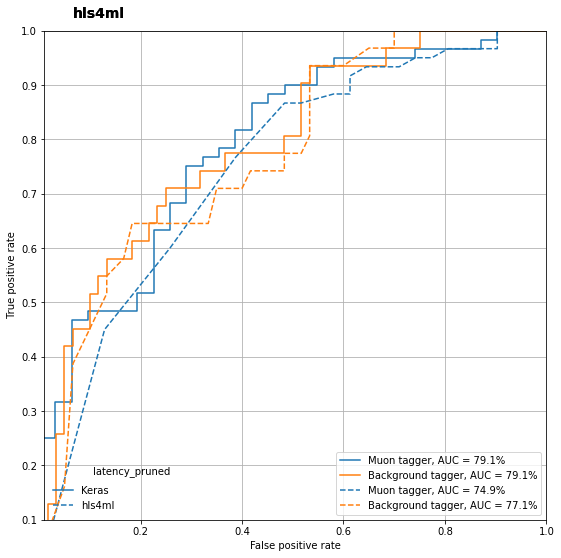

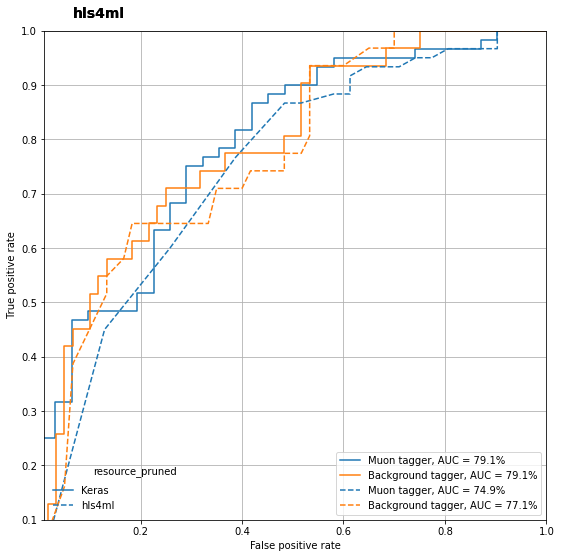

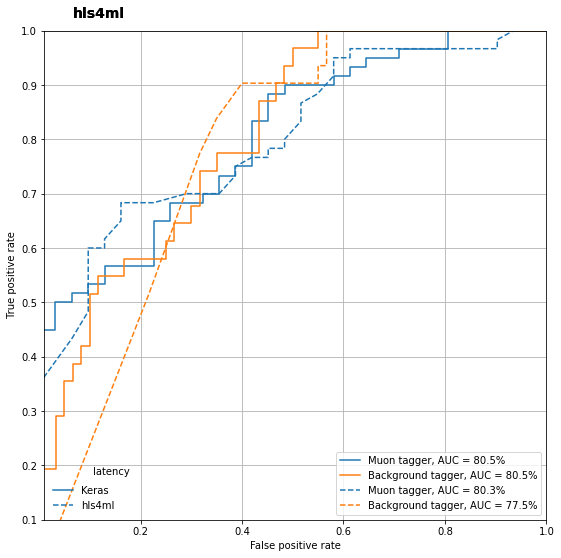

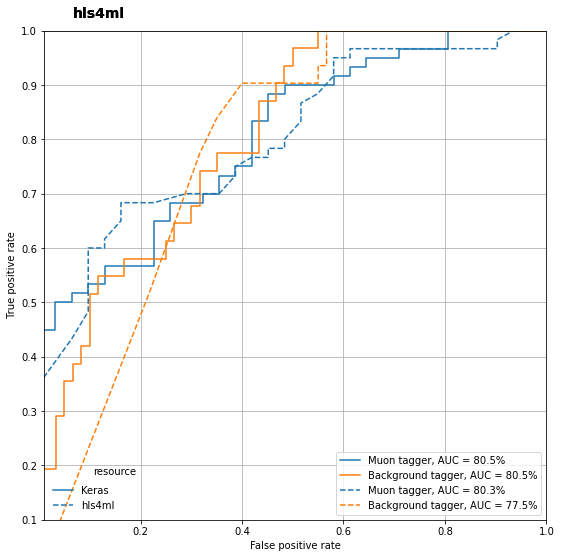

In [28]:
import plotting
from sklearn.metrics import accuracy_score

def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred,axis=1)))
    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred,labels=['Muon','Background']) #plot
    plt.gca().set_prop_cycle(None) # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, linestyle='--',labels=['Muon','Background']) #plot

    from matplotlib.lines import Line2D
    lines = [Line2D([0], [0], ls='-'),
             Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend
    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'],
                loc='lower left', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.2,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.xlim(0.01,1.)
    plt.ylim(0.1,1.)

# Plot the pruned latency model:    
plotROC(test3_y,y_predict_pruned,y_predict_hls4ml_latency_pruned,label="latency_pruned") 

# Plot the pruned resource model
plotROC(test3_y,y_predict_pruned,y_predict_hls4ml_resource_pruned,label="resource_pruned")

# Plot the pruned latency model:    
plotROC(test3_y,y_predict,y_predict_hls4ml_latency,label="latency") 

# Plot the pruned resource model
plotROC(test3_y,y_predict,y_predict_hls4ml_resource,label="resource")

In [29]:
import os
os.environ['PATH'] = '/home/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

In [30]:
synth = True # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model_latency.build(csim=False, synth=True, vsynth=True)
    hls_model_resource.build(csim=False, synth=True, vsynth=True)

In [31]:
import pprint 

data_latency = getReports('latency_muon')
data_resource = getReports('resource_muon')

print("\n Resource usage and latency: Latency ")
pprint.pprint(data_latency)
print("\n Resource usage and latency: Resource ")
pprint.pprint(data_resource)

Found valid vsynth and synth in latency_muon! Fetching numbers
Found valid vsynth and synth in resource_muon! Fetching numbers

 Resource usage and latency: Latency 
{'bram': 105.0,
 'bram_rel': 3.91,
 'dsp': 6495,
 'dsp_rel': 52.86,
 'ff': 55729,
 'ff_rel': 1.61,
 'latency_clks': 1325,
 'latency_ii': 1300,
 'latency_mus': 6.625,
 'lut': 248238,
 'lut_rel': 14.37}

 Resource usage and latency: Resource 
{'bram': 105.0,
 'bram_rel': 3.91,
 'dsp': 6513,
 'dsp_rel': 53.0,
 'ff': 116663,
 'ff_rel': 3.38,
 'latency_clks': 9098,
 'latency_ii': 9073,
 'latency_mus': 45.49,
 'lut': 107004,
 'lut_rel': 6.19}


In [32]:
synth = True # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model_latency_pruned.build(csim=False, synth=True, vsynth=True)
    hls_model_resource_pruned.build(csim=False, synth=True, vsynth=True)

In [33]:
import pprint 

data_latency_p = getReports('pruned_latency_muon')
data_resource_p = getReports('pruned_resource_muon')

print("\n Resource usage and latency: Latency pruned")
pprint.pprint(data_latency_p)
print("\n Resource usage and latency: Resource pruned")
pprint.pprint(data_resource_p)

Found valid vsynth and synth in pruned_latency_muon! Fetching numbers
Found valid vsynth and synth in pruned_resource_muon! Fetching numbers

 Resource usage and latency: Latency pruned
{'bram': 105.0,
 'bram_rel': 3.91,
 'dsp': 5403,
 'dsp_rel': 43.97,
 'ff': 46933,
 'ff_rel': 1.36,
 'latency_clks': 1325,
 'latency_ii': 1300,
 'latency_mus': 6.625,
 'lut': 116741,
 'lut_rel': 6.76}

 Resource usage and latency: Resource pruned
{'bram': 105.0,
 'bram_rel': 3.91,
 'dsp': 6514,
 'dsp_rel': 53.01,
 'ff': 89511,
 'ff_rel': 2.59,
 'latency_clks': 9098,
 'latency_ii': 9073,
 'latency_mus': 45.49,
 'lut': 109187,
 'lut_rel': 6.32}


In [34]:
timing = False

clk_latency = 1325
clk_resource = 9098
clk_latency_pruned = 1325
clk_resource_pruned = 9098

clk = 5e-9
clk_std = 6.2e-10

FPGA_time_latency = clk_latency*clk
FPGA_time_resource = clk_resource*clk
FPGA_time_latency_pruned = clk_latency_pruned*clk
FPGA_time_resource_pruned = clk_resource_pruned*clk

FPGA_time_latency_std = clk_latency*clk_std
FPGA_time_resource_std = clk_resource*clk_std
FPGA_time_latency_pruned_std = clk_latency_pruned*clk_std
FPGA_time_resource_pruned_std = clk_resource_pruned*clk_std

x = np.array([5,50,91])
if timing:
    pruned = []
    cnn = []
    for i,f in enumerate(x):
        _pruned = %timeit -o -r 100 -n 1000 model_pruned(test_x[:f],training=False)
        pruned.append(_pruned)
        _cnn = %timeit -o -r 100 -n 1000 model(test_x[:f],training=False)
        cnn.append(_cnn)
    t_p, t_std_p = [f.average for f in pruned], [f.stdev for f in pruned]
    t, t_std = [f.average for f in cnn], [f.stdev for f in cnn]
    time = np.array([t_p,t_std_p,t,t_std])
    np.save('timing_muon.npy',time)
else:
    time = np.load('timing_muon.npy')
    
    
FPGA_time_latency_arr = x*FPGA_time_latency
FPGA_time_resource_arr = x*FPGA_time_resource
FPGA_time_latency_pruned_arr = x*FPGA_time_latency_pruned
FPGA_time_resource_pruned_arr = x*FPGA_time_resource_pruned

FPGA_time_latency_std_arr = x*FPGA_time_latency_std
FPGA_time_resource_std_arr = x*FPGA_time_resource_std
FPGA_time_latency_pruned_std_arr = x*FPGA_time_latency_pruned_std
FPGA_time_resource_pruned_std_arr = x*FPGA_time_resource_pruned_std

speed_latency_pruned = np.divide(time[0],FPGA_time_latency_pruned_arr)
speed_resource_pruned = np.divide(time[0],FPGA_time_resource_pruned_arr)

speed_latency = np.divide(time[0],FPGA_time_latency_arr)
speed_resource = np.divide(time[0],FPGA_time_resource_arr)

latency_pruned_std= np.multiply(np.divide(time[1],time[0])+np.divide(FPGA_time_latency_pruned_std_arr,FPGA_time_latency_pruned_arr),speed_latency_pruned)
resource_pruned_std= np.multiply(np.divide(time[1],time[0])+np.divide(FPGA_time_resource_pruned_std_arr,FPGA_time_resource_pruned_arr),speed_resource_pruned)

latency_std = np.multiply(np.divide(time[3],time[2])+np.divide(FPGA_time_latency_std_arr,FPGA_time_latency_arr),speed_latency)
resource_std = np.multiply(np.divide(time[3],time[2])+np.divide(FPGA_time_resource_std_arr,FPGA_time_resource_arr),speed_resource)



In [254]:
plt.rcParams.update({'font.size': 22})

Accuracy Keras:  0.7692307692307693
Accuracy hls4ml: 0.7472527472527473
Accuracy hls4ml: 0.7472527472527473
Accuracy Keras:  0.6813186813186813
Accuracy hls4ml: 0.7032967032967034
Accuracy hls4ml: 0.7032967032967034


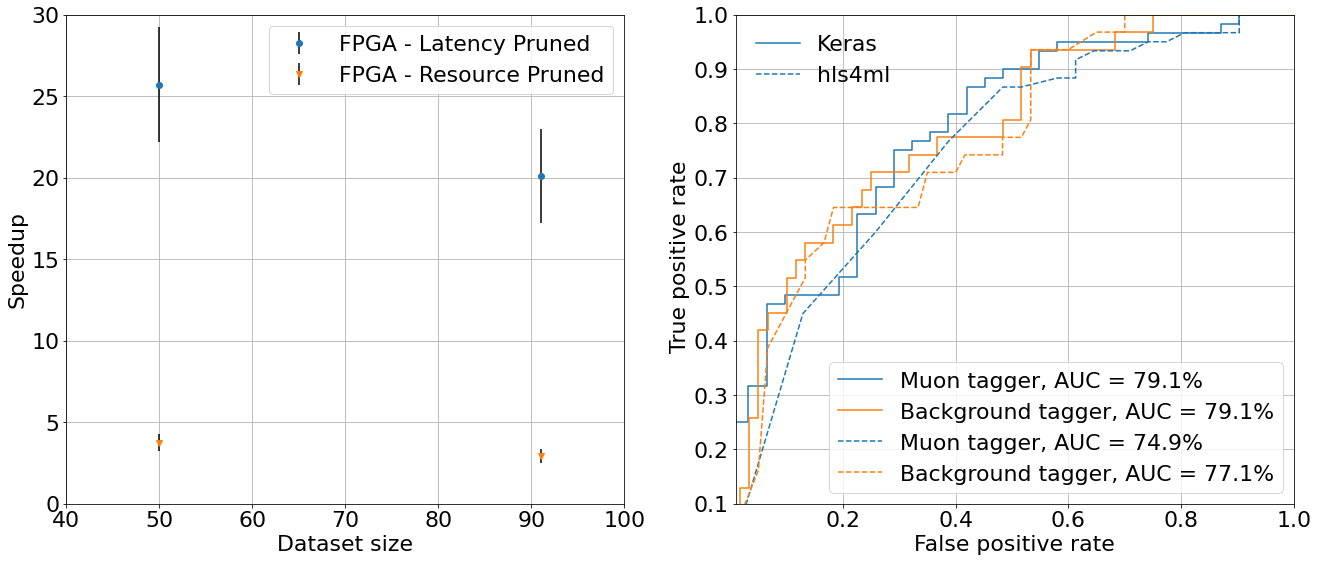

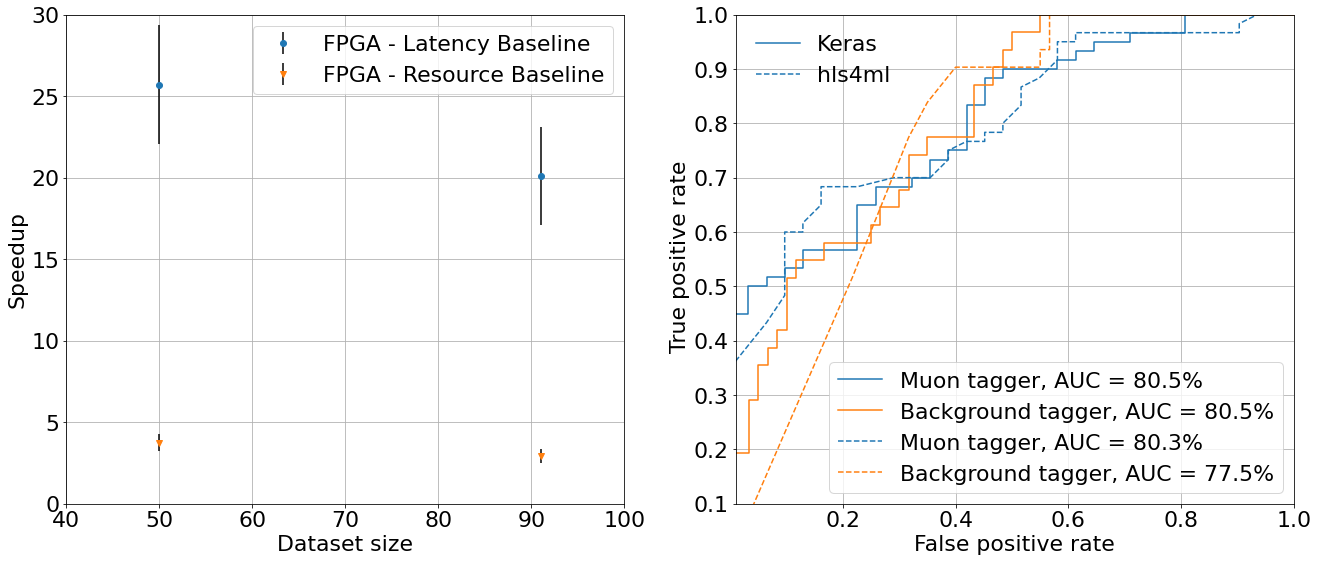

In [260]:
import plotting
from sklearn.metrics import accuracy_score

def plot2(Y, y_pred, y_pred_hls4ml, y_pred_hls4ml2,datasize,speed_l,speed_r,std_l,std_r,file, label="Model"):
    
    accuracy_keras  = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred,axis=1)))
    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1)))
    
    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml2,axis=1)))
    
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, axarr = plt.subplots(1,2,figsize=(22, 9))
    _ = plotting.makeRoc(Y, y_pred,labels=['Muon','Background']) #plot
    plt.gca().set_prop_cycle(None) # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, linestyle='--',labels=['Muon','Background']) #plot
    #_ = plotting.makeRoc(Y, y_pred_hls4ml2, linestyle='-.',labels=['Muon','Background']) #plot

    from matplotlib.lines import Line2D
    lines = [Line2D([0], [0], ls='-'),
             Line2D([0], [0], ls='--'),]
             #Line2D([0], [0], ls='-.')]
    from matplotlib.legend import Legend
    leg = Legend(axarr[1], lines, labels=['Keras', 'hls4ml'],
                loc='upper left', frameon=False)
    axarr[1].add_artist(leg)
    plt.ylabel(" True positive rate")
    #plt.figtext(0.2, 0.2,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.xlim(0.01,1.)
    plt.ylim(0.1,1.)
    
    plt.sca(axarr[0])
    plt.errorbar(datasize,speed_l,yerr=std_l,fmt='o',ecolor='k',label=label[0])
    plt.errorbar(datasize,speed_r,yerr=std_r,fmt='v',ecolor='k',label=label[1])
    
    plt.xlim(40,100)
    plt.xlabel('Dataset size')
    plt.ylim(0,30)
    plt.ylabel('Speedup')
    plt.legend()
    plt.grid()
    plt.savefig(file)
    #plt.title('Speedup of Muon detection on FPGA over Ryzen 7 5800X')
# Plot the pruned latency model:    
plot2(test3_y,y_predict_pruned,y_predict_hls4ml_latency_pruned,y_predict_hls4ml_resource_pruned,x,speed_latency_pruned,speed_resource_pruned,latency_pruned_std,resource_pruned_std,'pruned_muon.pdf',label=["FPGA - Latency Pruned","FPGA - Resource Pruned"]) 


plot2(test3_y,y_predict,y_predict_hls4ml_latency,y_predict_hls4ml_resource,x,speed_latency,speed_resource,latency_std,resource_std,'muon.pdf',label=["FPGA - Latency Baseline","FPGA - Resource Baseline"]) 
# Plot the pruned resource model
#plotROC(test3_y,y_predict_pruned,y_predict_hls4ml_resource_pruned,label="resource_pruned")

# Plot the pruned latency model:    
#plotROC(test3_y,y_predict,y_predict_hls4ml_latency,label="latency") 

# Plot the pruned resource model
#plotROC(test3_y,y_predict,y_predict_hls4ml_resource,label="resource")

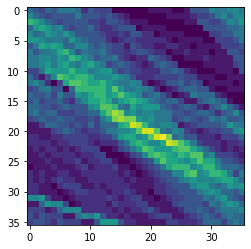

In [53]:
plt.imshow(test_x[5,:,:,:])

In [111]:
test_y[testMASK]

array([[  0.,   0.,   0.,   0.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  1.,   1., 155., 156.],
       [  

In [110]:
mask_min+36

170

NameError: name 'test2_x' is not defined

In [54]:
from network_lib import test_x as test2_x

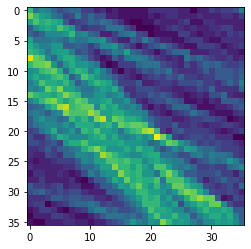

In [93]:
plt.imshow(test_x[1,:,:,:])
#plt.xlim(mask_min,mask_max)
#plt.ylim(mask_min,mask_max)

In [146]:
HDF5=True
if HDF5:
    #Train HDF5 file
    MinBiastrainstorage = pd.HDFStore(MinBiasdir + MinBiastrainfilename)
    LoneMuontrainstorage = pd.HDFStore(LoneMuondir + LoneMuontrainfilename)

    #Train key list to file
    Minbiastrainlist = MinBiastrainstorage.keys()
    LoneMuontrainlist = LoneMuontrainstorage.keys()

    #Length of lists
    nMinbiastrainlist = len(Minbiastrainlist)
    nLoneMuontrainlist = len(LoneMuontrainlist)

    ntrainmax = np.min((len(Minbiastrainlist), len(LoneMuontrainlist)))



    MinBiasvalidstorage = pd.HDFStore(MinBiasdir + MinBiasvalidfilename)
    LoneMuonvalidstorage = pd.HDFStore(LoneMuondir + LoneMuonvalidfilename)

    Minbiasvalidlist = MinBiasvalidstorage.keys()
    LoneMuonvalidlist = LoneMuonvalidstorage.keys()

    nMinbiasvalidlist = len(Minbiasvalidlist)
    nLoneMuonvalidlist = len(LoneMuonvalidlist)

    nvalidmax = np.min((len(Minbiasvalidlist), len(LoneMuonvalidlist)))



    MinBiasteststorage = pd.HDFStore(MinBiasdir + MinBiastestfilename)
    LoneMuonteststorage = pd.HDFStore(LoneMuondir + LoneMuontestfilename)

    Minbiastestlist = MinBiasteststorage.keys()
    LoneMuontestlist = LoneMuonteststorage.keys()

    nMinbiastestlist = len(Minbiastestlist)
    nLoneMuontestlist = len(LoneMuontestlist)

    ntestmax = np.min((len(Minbiastestlist), len(LoneMuontestlist)))



    MinBiasvalidpteststorage = pd.HDFStore(MinBiasdir + MinBiasvalidptestfilename)
    LoneMuonvalidpteststorage = pd.HDFStore(LoneMuondir + LoneMuonvalidptestfilename)

    Minbiasvalidptestlist = MinBiasvalidpteststorage.keys()
    LoneMuonvalidptestlist = LoneMuonvalidpteststorage.keys()

    nMinbiasvalidptestlist = len(Minbiasvalidptestlist)
    nLoneMuonvalidptestlist = len(LoneMuonvalidptestlist)

    # nvalidptestmax = np.min((len(Minbiasvalidptestlist), len(LoneMuonvalidptestlist)))
    nvalidptestmax = nLoneMuonvalidptestlist #UPDATED this is better when using the deterministic shuffle, but not the random one.


    nmax = ntrainmax

    def get_saved_truth(df):
        n_events = int(len(df.index)/nSl/nL)

        truthlist = []
        for i in range(n_events):
            for j in range(nSl):
                iqOpT = df['truth_qOpT'].iloc[i*nSl*nL + j*nL]
                if iqOpT != -1:
                    iphi0 = df['truth_phi0'].iloc[i*nSl*nL + j*nL]

                    truthlist += [[i, j, iqOpT, iphi0]]

        return truthlist

    def get_images_allslices(df):
        n_events = int(len(df.index)/nSl/nL)

        images = torch.empty(0,nSl,nL,nbinsQOpT,nbinsphi0, dtype = torch.int)
        for i in range(n_events):
            slices = torch.empty(0,nL,nbinsQOpT,nbinsphi0, dtype = torch.int)
            for j in range(nSl):
                layers = torch.empty(0,nbinsQOpT,nbinsphi0, dtype = torch.int)
                for k in range(nL):
                    layer = torch.zeros((nbinsQOpT,nbinsphi0), dtype = torch.int)
                    layerx = df['x_pos'].iloc[i*nSl*nL + j*nL + k]
                    layery = df['y_pos'].iloc[i*nSl*nL + j*nL + k]
                    value = df['value'].iloc[i*nSl*nL + j*nL + k]
                    layerxnp = ak.to_numpy(layerx).astype(int)
                    layerynp = ak.to_numpy(layery).astype(int)
                    valuenp = ak.to_numpy(value).astype(int)
                    layer[layerynp,layerxnp] = torch.from_numpy(valuenp)

                    layers = torch.cat((layers, layer.unsqueeze(0)),0)

                slices = torch.cat((slices, layers.unsqueeze(0)),0)

            images = torch.cat((images, slices.unsqueeze(0)),0)

        return images.numpy()


In [147]:

    _arr = np.zeros((220,228))
    _arry = np.zeros(4)
    train_set_x = np.array([_arr])
    train_set_y = np.array([_arry])


    for i ,f in enumerate(LoneMuontrainlist):
        LMtrain = LoneMuontrainstorage[f]
        truth = get_saved_truth(LMtrain)
        LMimage = get_images_allslices(LMtrain)
        print(f)
        #if f=='/lonemuon1346_13':
         #   break
        for name in Minbiastrainlist[i:i+6]:
            try:
                MBtrain = MinBiastrainstorage[name]
                MBimage = get_images_allslices(MBtrain)
            except:
                continue
            for t in truth:
                train_set_x = np.append(train_set_x,[np.sum(MBimage[0,0],axis=0)+np.sum(LMimage[t[0],t[1]],axis=0)],axis=0)
                train_set_y = np.append(train_set_y,[np.array([1,1,t[2],t[3]])],axis=0)

TypeError: only size-1 arrays can be converted to Python scalars

In [153]:
def get_images_allslices(df):
    n_events = int(len(df.index)/nSl/nL)

    images = torch.empty(0,nSl,nL,nbinsQOpT,nbinsphi0, dtype = np.int)
    for i in range(n_events):
        slices = torch.empty(0,nL,nbinsQOpT,nbinsphi0, dtype = np.int)
        for j in range(nSl):
            layers = torch.empty(0,nbinsQOpT,nbinsphi0, dtype = np.int)
            for k in range(nL):
                layer = torch.zeros((nbinsQOpT,nbinsphi0), dtype = np.int)
                layerx = df['x_pos'].iloc[i*nSl*nL + j*nL + k]
                layery = df['y_pos'].iloc[i*nSl*nL + j*nL + k]
                value = df['value'].iloc[i*nSl*nL + j*nL + k]
                layerxnp = ak.to_numpy(layerx).astype(np.int)
                layerynp = ak.to_numpy(layery).astype(np.int)
                valuenp = ak.to_numpy(value).astype(np.int)
                layer[layerynp,layerxnp] = torch.from_numpy(valuenp)

                layers = torch.cat((layers, layer.unsqueeze(0)),0)

            slices = torch.cat((slices, layers.unsqueeze(0)),0)

        images = torch.cat((images, slices.unsqueeze(0)),0)

    return images.numpy()

In [154]:
LMtest = LoneMuonteststorage[LoneMuontestlist[21]]
truth = get_saved_truth(LMtest)
LMimage = get_images_allslices(LMtest)
truth[-1]

[7, 2, 155.0, 156.0]

In [175]:

MBtrain = MinBiastrainstorage['/minbias102']
MBimage = get_images_allslices(MBtrain)

<ipython-input-153-0f7e5c35e44d>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = torch.empty(0,nSl,nL,nbinsQOpT,nbinsphi0, dtype = np.int)
<ipython-input-153-0f7e5c35e44d>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

In [181]:
nbinsphi0 = 216+2*6 #phi-bins
nbinsQOpT = 216+2*2 #pT-bins

size_x = nbinsphi0
size_y = nbinsQOpT

phi0min0 = 0.3 #phi-range (excluding padding)
phi0max0 = 0.5

phi0minstep = (phi0max0-phi0min0)/216 #phi-bin-size

phi0minmin = phi0min0 - 6*phi0minstep #Minimal phi-value including padding
phi0minmid = phi0minmin + 0.5*phi0minstep #Mid of lowest phi bin


QOpTmin0 = -1
QOpTmax0 = 1 #GeV^-1

QOpTminstep = (QOpTmax0-QOpTmin0)/216

QOpTminmin = QOpTmin0 - 2*QOpTminstep
QOpTminmid = QOpTminmin + 0.5*QOpTminstep

In [183]:
QOpTminmid

-1.013888888888889

In [189]:
import matplotlib.colors as colors

In [211]:
[mask_min:mask_max]

SyntaxError: invalid syntax (<ipython-input-211-0bc71a138790>, line 1)

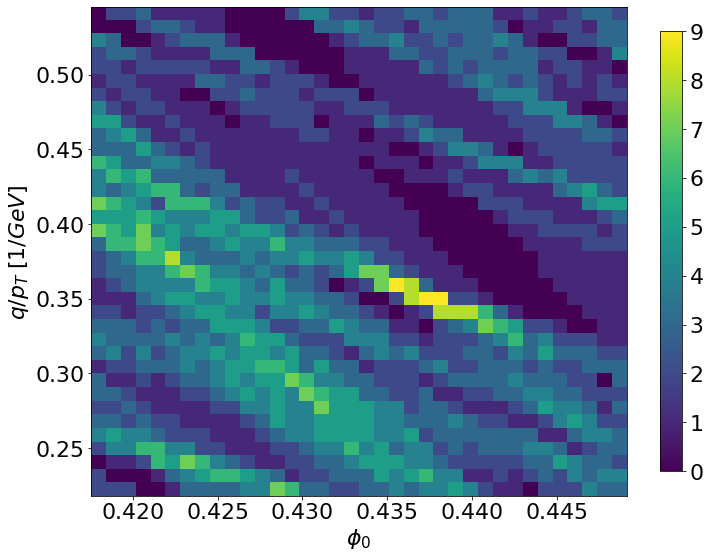

In [257]:
fig, ax = plt.subplots(figsize=(12,9))
pos = ax.imshow((np.sum(LMimage[7,2],axis=0)+np.sum(MBimage[2,2],axis=0))[mask_min:mask_max,mask_min:mask_max],extent=[phi0min0+mask_min*(0.5-0.3)/228, phi0min0+mask_max*(0.5-0.3)/228, QOpTmin0+1.2181818181818183, QOpTmin0+1.5454545454545454],aspect='auto')
#ax.plot(155.0*(0.2)/228+0.3,156.0*(2)/220-1)
fig.colorbar(pos, ax=ax, anchor=(0, 0.3), shrink=0.9)
ax.set_xlabel(r'$\phi_0$')
ax.set_ylabel(r'$q/p_T\; [1/GeV]$')
plt.savefig('small_hough.pdf')
#plt.xlim(mask_min,mask_max)
#plt.ylim(mask_min,mask_max)

In [250]:
155.0*(0.2)/228+0.3

0.4359649122807018

In [249]:
156.0*(2)/220-1

1.4181818181818182

In [235]:
len((np.sum(LMimage[7,2],axis=0)+np.sum(MBimage[2,2],axis=0))[0])

228

In [242]:
0.3+228*(0.5-0.3)/228

0.5

In [258]:
[phi0min0+mask_min*(0.5-0.3)/228, phi0min0+mask_max*(0.5-0.3)/228, QOpTmin0+1.2181818181818183, QOpTmin0+1.5454545454545454]

[0.4175438596491228,
 0.4491228070175438,
 0.21818181818181825,
 0.5454545454545454]